## Milky way

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import animation
from tqdm.notebook import tqdm
from IPython.display import HTML

plt.style.use('../../sim.mplstyle')
%config InlineBackend.figure_format = 'retina'

In [2]:
import sys
sys.path.insert(1, '../')
from gdsam import initial_data

We will start from the density and later derive the potential. Since the density is found from the laplacian of the potential, as the Poisson equation dictates, if we already know the density profile of the three objects, namely the DM halo, the bulge and the galaxy, we know for sure that

$$
    \phi = \phi_\mathrm{DM} + \phi_\mathrm{bulge} + \phi_\mathrm{gal}
$$

for linearity 
$$ \nabla^2 \phi = \nabla^2\phi_\mathrm{DM} + \nabla^2\phi_\mathrm{bulge} + \nabla^2\phi_\mathrm{gal}$$

therefore
$$ \rho = \rho_\mathrm{DM} + \rho_\mathrm{bulge} + \rho_\mathrm{gal} $$


### DM Halo and Bulge

$$ 
    \rho_\mathrm{DM} = \rho_0\left(\dfrac{r}{a}\right)^{-\gamma}\left[1 + \left(\dfrac{r}{a}\right)^{\gamma- \beta}\right]\exp{\left[-\left(\dfrac{r}{r_c}\right)^2\right]}
$$
We needed a spherical potential, we chose a complicated one, the double power law potential 'spheroidal' with a cutoff term (called taper, we will neglect this one) at the scale radius $r_c$.
The variables are:
- $\rho_0 :=$ density normalization
- $a :=$ scale radius
- $r_c :=$ outer cut-off radius
- $\beta :=$ outer power-law slope
- $\gamma :=$ inner power-law slope

The parameters are taken from the [following paper](https://arxiv.org/pdf/2111.05466). We will report them here converted in internal units

### DM Halo
$$
    M_\mathrm{tot} = 117\times 10^{10}\  M_\odot \qquad a = 19\ \mathrm{kpc} \qquad r_c = 250\ \mathrm{kpc} \qquad \beta = 3 \qquad \gamma = 1
$$

the velocity will be 

$$
    v = \sqrt{GM/a} = 523.3 \ \mathrm{km/s}
$$

As corresponding internal units we will take

$1\ r_\mathrm{IU} = 1 \ \mathrm{kpc}$ $\qquad$ $1\ M_\mathrm{IU} = 10^{10} M_\odot$ $\qquad$ $1\ v_\mathrm{IU} = 1\ \mathrm{km/s}$ $\qquad$ $t_\mathrm{IU} = 1\ \mathrm{Myr}$

In [3]:
def f(r, rho_0, a, gamma, beta):
    return rho_0*(r/a)**(-gamma)*(1+(r/a))**(gamma-beta)

In [4]:
# DM HALO
a = 19
b = 3
gamma = 1
M_tot = 117
rho_0 = 3*M_tot/(4*np.pi*a**3)

v_c = 523.3 

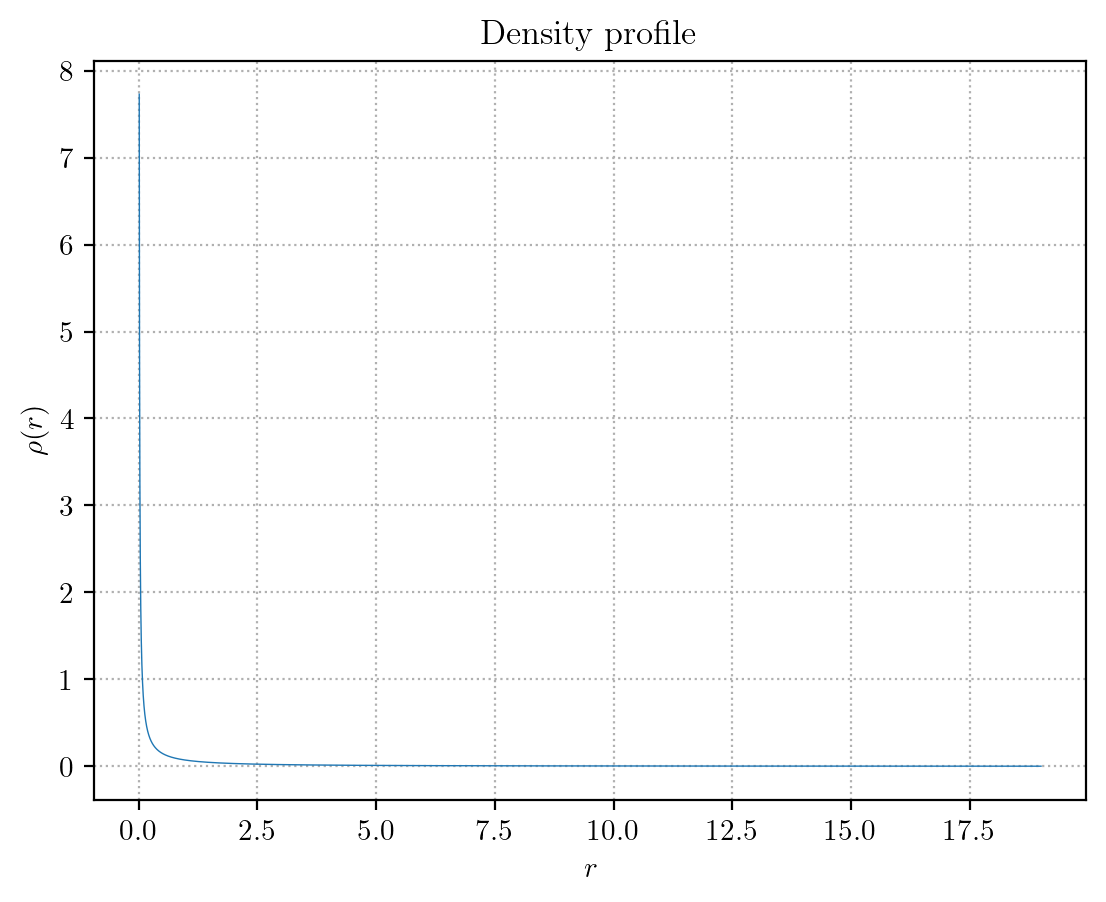

In [5]:
r_test = np.linspace(.01, a, int(1e6))
y_dm = f(r_test, rho_0, a, gamma, b)

plt.plot(r_test, y_dm)
plt.xlabel(r'$r$')
plt.ylabel(r'$\rho(r)$')
plt.title(r'Density profile')
plt.grid()
plt.show();

In [6]:
def rejection_sampling(f, num_samples):
    samples = []
    
    r_test = np.linspace(.01, a, int(1e6))
    y_dm = f(r_test, rho_0, a, gamma, b)
    g = np.max(y_dm)
    
    with tqdm(total=num_samples, desc='Sampling') as pbar:
        while len(samples) < num_samples:
            
            q_i = np.random.uniform(0, a)
            u = np.random.uniform(0, 1)
            
            # Accept or reject the candidate
            if u < f(q_i, rho_0, a, gamma, b) / g: 
                samples.append(q_i)
                pbar.update(1)
                
    return np.array(samples)

In [7]:
N = int(1e4)

r = rejection_sampling(f, N)

Sampling:   0%|          | 0/10000 [00:00<?, ?it/s]

In [8]:
theta_cdf = np.random.uniform(0,1,N)
theta = np.arccos(1 - 2 * theta_cdf)
phi = np.random.uniform(0, 2*np.pi, N)

x = r * np.sin(theta) * np.cos(phi)
y = r * np.sin(theta) * np.sin(phi)
z = r * np.cos(theta)

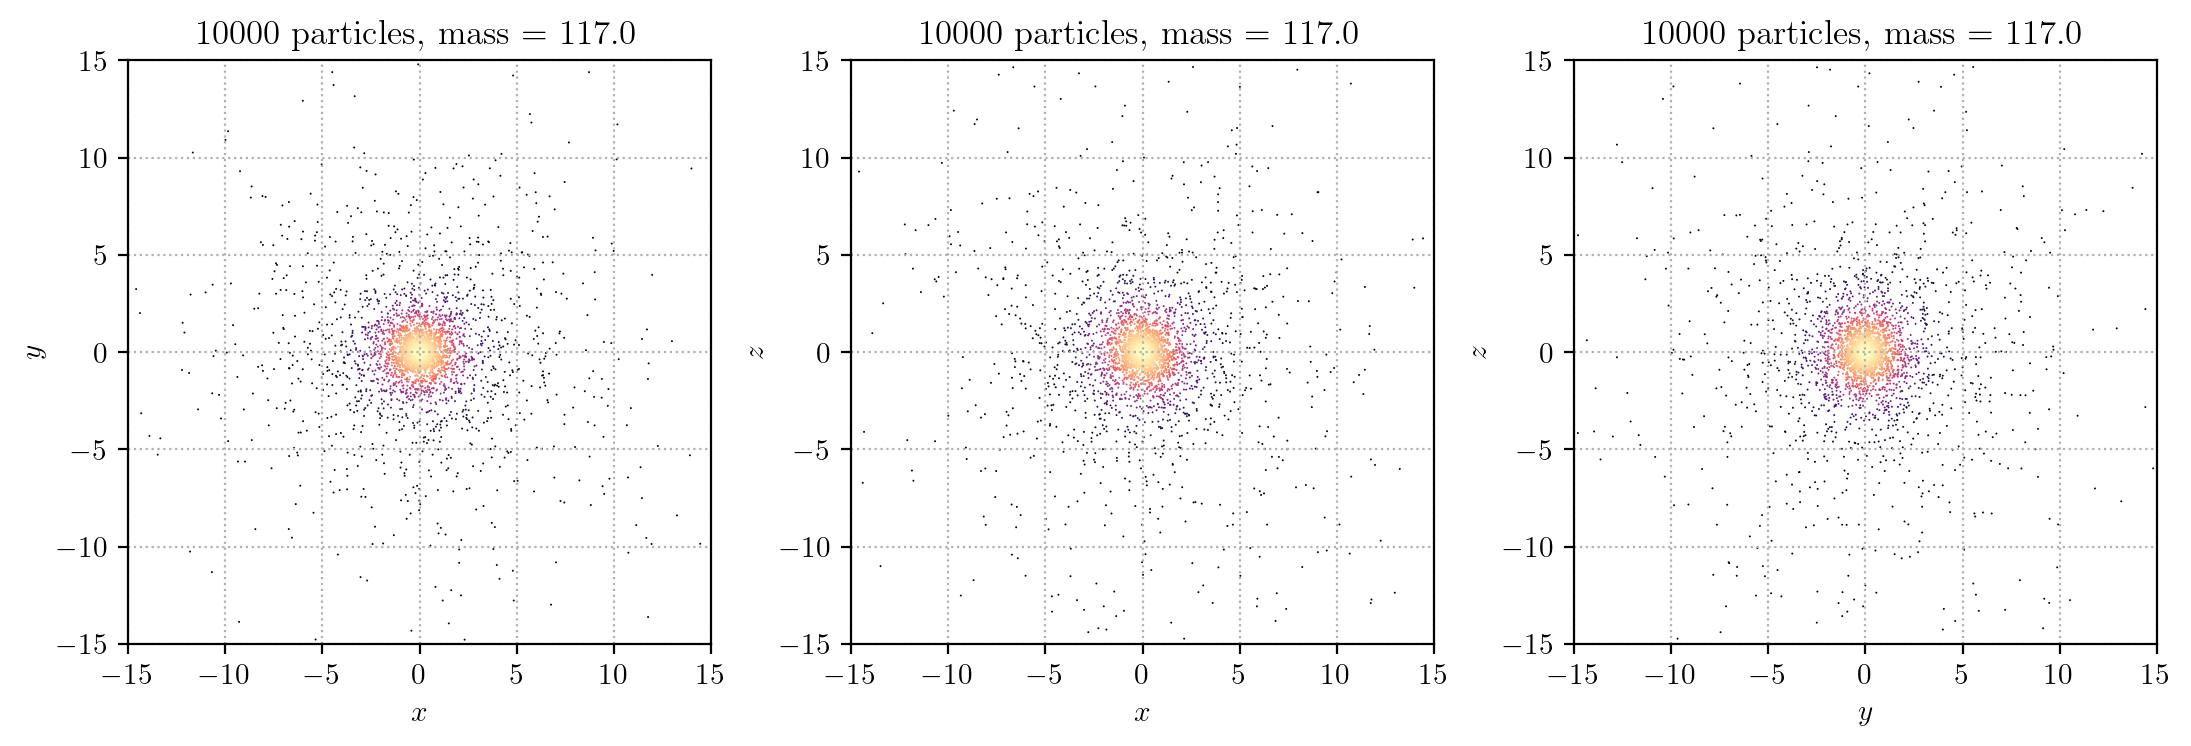

In [9]:
from gdsam import initial_data

halo = initial_data()
halo.set_positions(N, M_tot, x,y,z)

halo.projections(l=15, s=.5, a=1)

plt.show()

### Stellar Bulge
$$
    M_\mathrm{tot} = 1.3\times 10^{10}\  M_\odot \qquad a = 0.6\ \mathrm{kpc} \qquad r_c = 2\ \mathrm{kpc} \qquad \beta = 4 \qquad \gamma = 1
$$

the velocity will be 

$$
    v = \sqrt{GM/a} = 310.4 \ \mathrm{km/s}
$$

We will take $\rho/\rho_0$ as our pdf in cylindrical coordinates. And use a rejection sampling monte carlo approach

In [10]:
# BULGE
a = 0.6
b = 4
gamma = 1
M_tot = 1.3
rho_0 = 3*M_tot/(4*np.pi*a**3)

v_c = 310.4 

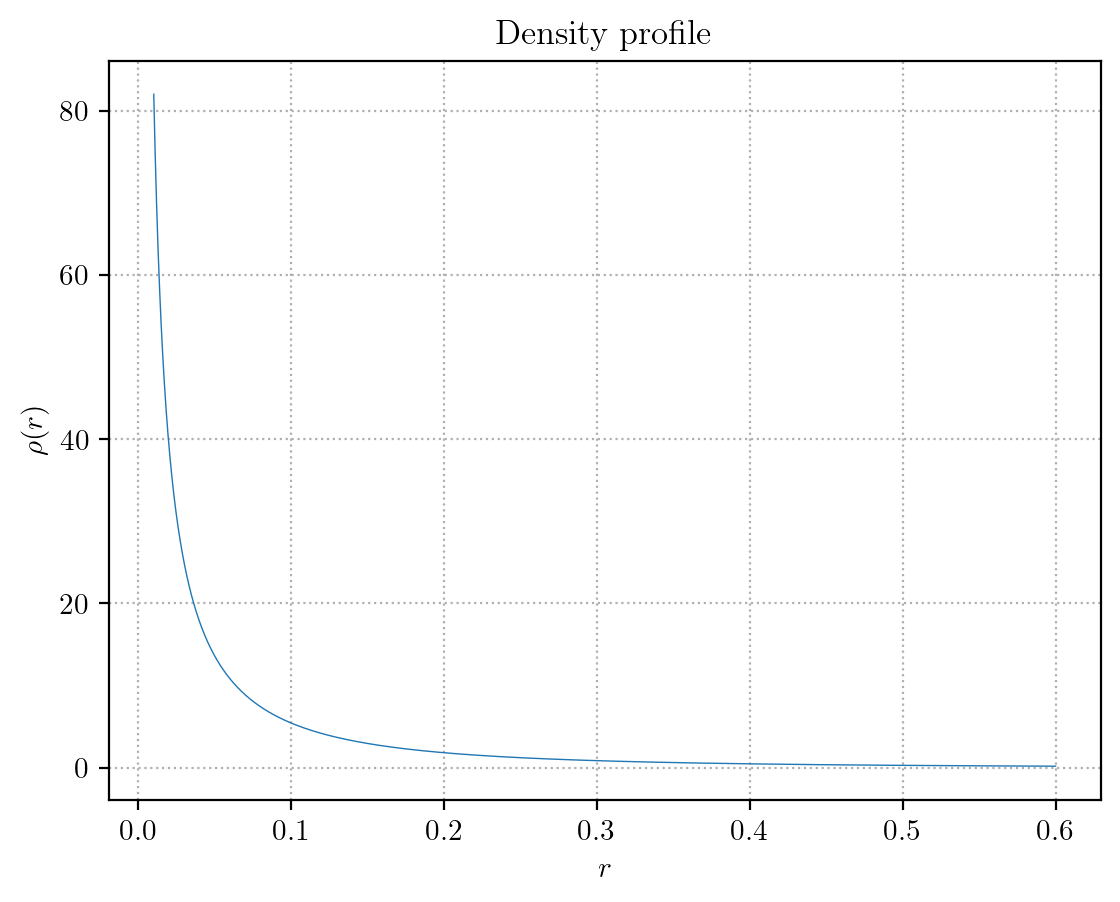

In [11]:
r_test = np.linspace(0.01, a, int(1e6))
y_b = f(r_test, rho_0, a, gamma, b)

plt.plot(r_test, y_b)
plt.xlabel(r'$r$')
plt.ylabel(r'$\rho(r)$')
plt.title(r'Density profile')
plt.grid()
plt.show();

In [12]:
N = int(1e4)

r = rejection_sampling(f, N)

Sampling:   0%|          | 0/10000 [00:00<?, ?it/s]

In [13]:
theta_cdf = np.random.uniform(0,1,N)
theta = np.arccos(1 - 2 * theta_cdf)
phi = np.random.uniform(0, 2*np.pi, N)

x = r * np.sin(theta) * np.cos(phi)
y = r * np.sin(theta) * np.sin(phi)
z = r * np.cos(theta)

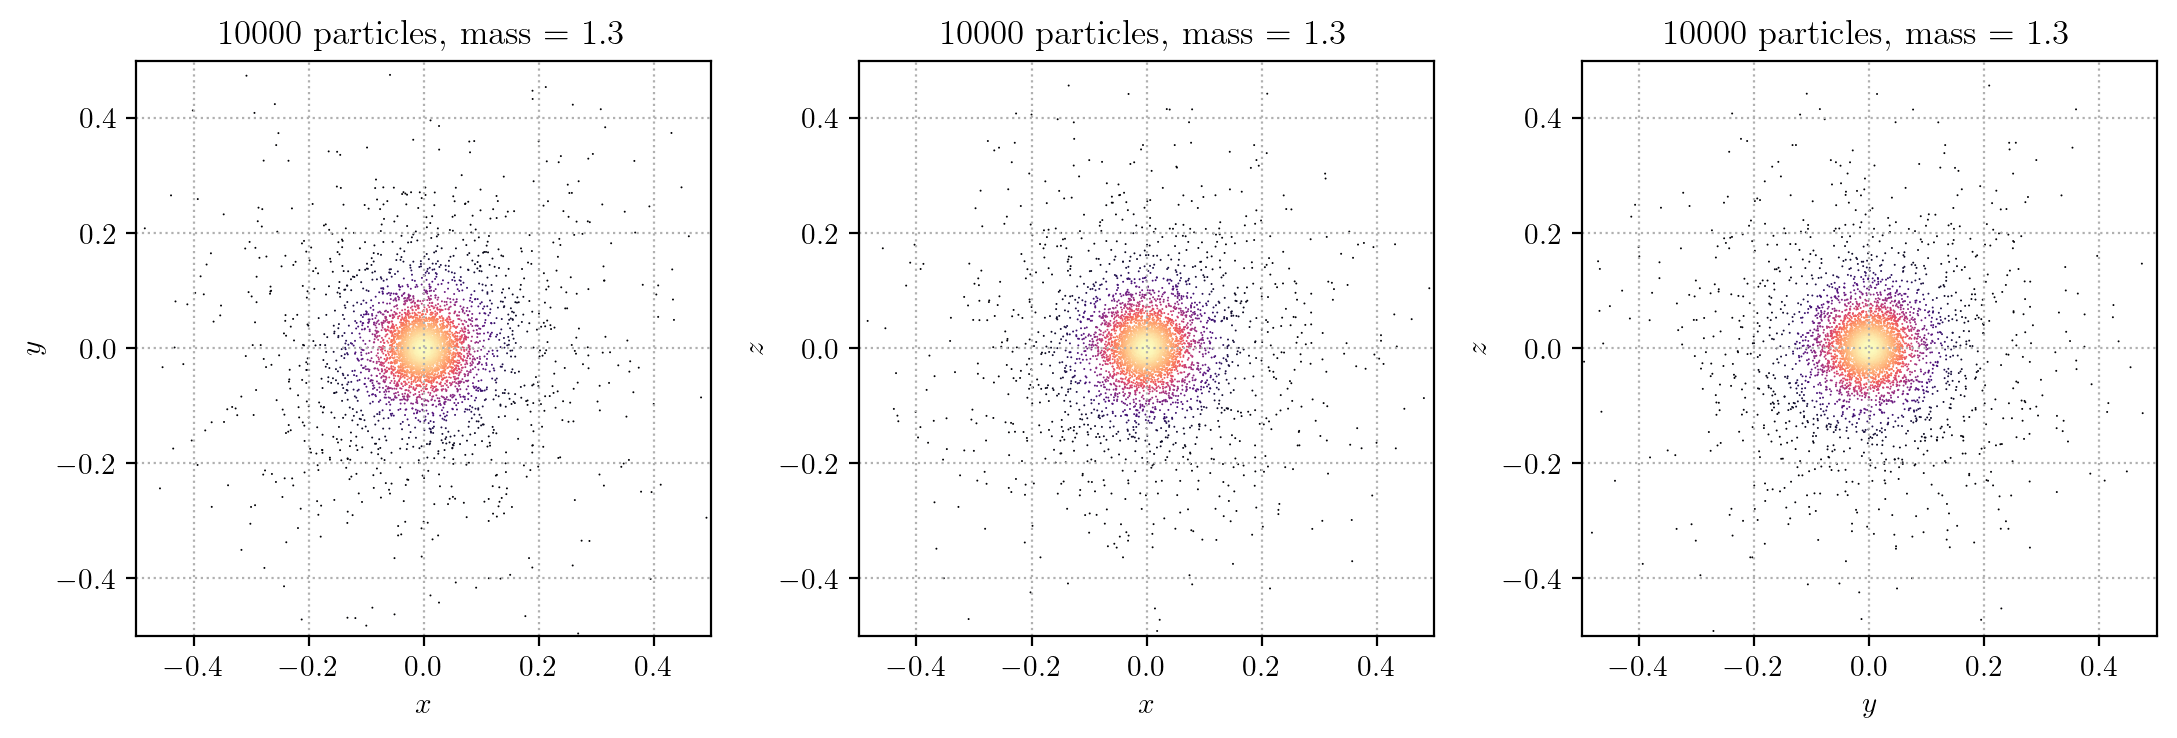

In [15]:
from gdsam import initial_data

bulge = initial_data()
bulge.set_positions(N, M_tot, x,y,z)

bulge.projections(l=0.5, s=.5, a=1)

plt.show()

### Disk
We choose an initial density profile of the form

$$
\rho_d(R, z) = \frac{\Sigma_0}{4|h|} \exp \left[ \frac{-R}{R_d} \right] \times \mathrm{sech}^2 \left( \frac{|z|}{2h} \right),
$$
with
- $\Sigma_0 :=$ surface density normalization
- $R_d :=$ scale length
- $h :=$ scale height

$$
    M_\mathrm{tot} = 4.3\times 10^{10}\  M_\odot \qquad
    R_d = 2.5 \ \mathrm{kpc} \qquad
    h = 0.3\ \mathrm{kpc} 
$$


again the velocity will be:


In [16]:
def f_d(r, z, sigma_0, R_d, h):
    return sigma_0/(4*abs(h))*np.exp(-r/R_d)*(1/np.cosh(abs(z)/(2*h)))**2

In [17]:
# DISK
M_d = 4.3
R_d = 2.5
h = 0.3

sigma_0 = M_d/(np.pi*R_d**2)

In [18]:
r = np.linspace(0, 3*R_d, int(1e3))
z = np.linspace(-5*h,5*h, int(1e3))

R,Z = np.meshgrid(r,z)
y_d = f_d(R, Z, sigma_0, R_d, h)

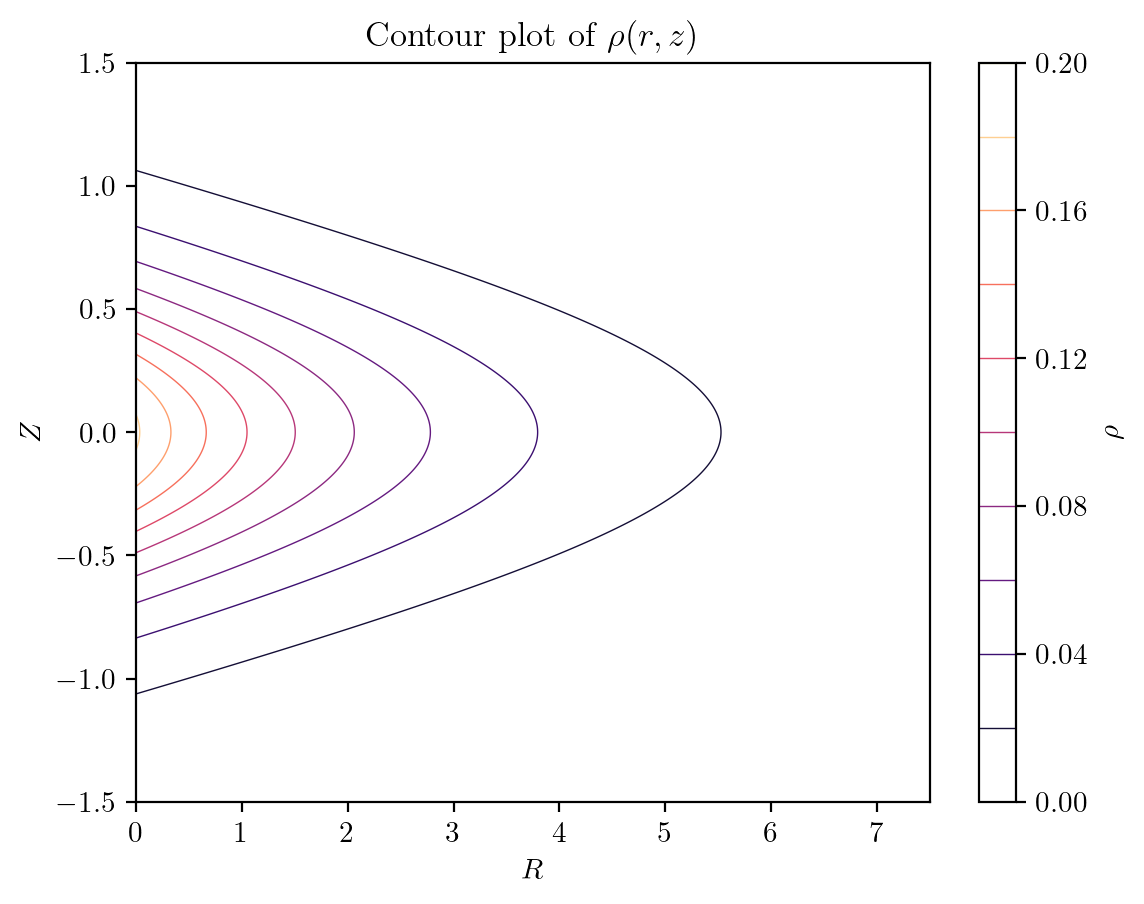

In [19]:
plt.contour(R,Z, y_d, 10)
plt.xlabel(r'$R$')
plt.ylabel(r'$Z$')
plt.colorbar(label=r'$\rho$')
plt.title(r'Contour plot of $\rho(r, z)$')
plt.show()

In [20]:
def rejection_sampling(f, num_samples):
    r_samples, z_samples = ([],[])
    
    r_test = np.linspace(.01, 5*R_d, int(1e6))
    z_test = np.linspace(-5*h, 5*h, int(1e6))
    y = f_d(r_test, z_test, sigma_0, R_d, h)
    g = np.max(y)
    
    with tqdm(total=num_samples, desc='Sampling') as pbar:
        while len(r_samples) < num_samples:
            
            r_i = np.random.uniform(0, 5*R_d)
            z_i = np.random.uniform(-5*h, 5*h)
            
            u = np.random.uniform(0, 1)
            
            # Accept or reject the candidate
            if u < f_d(r_i, z_i, sigma_0, R_d, h) / g: 
                r_samples.append(r_i)
                z_samples.append(z_i)
                pbar.update(1)
                
    return np.array(r_samples), np.array(z_samples)

In [21]:
N = int(1e4)

r,z = rejection_sampling(f, N)

Sampling:   0%|          | 0/10000 [00:00<?, ?it/s]

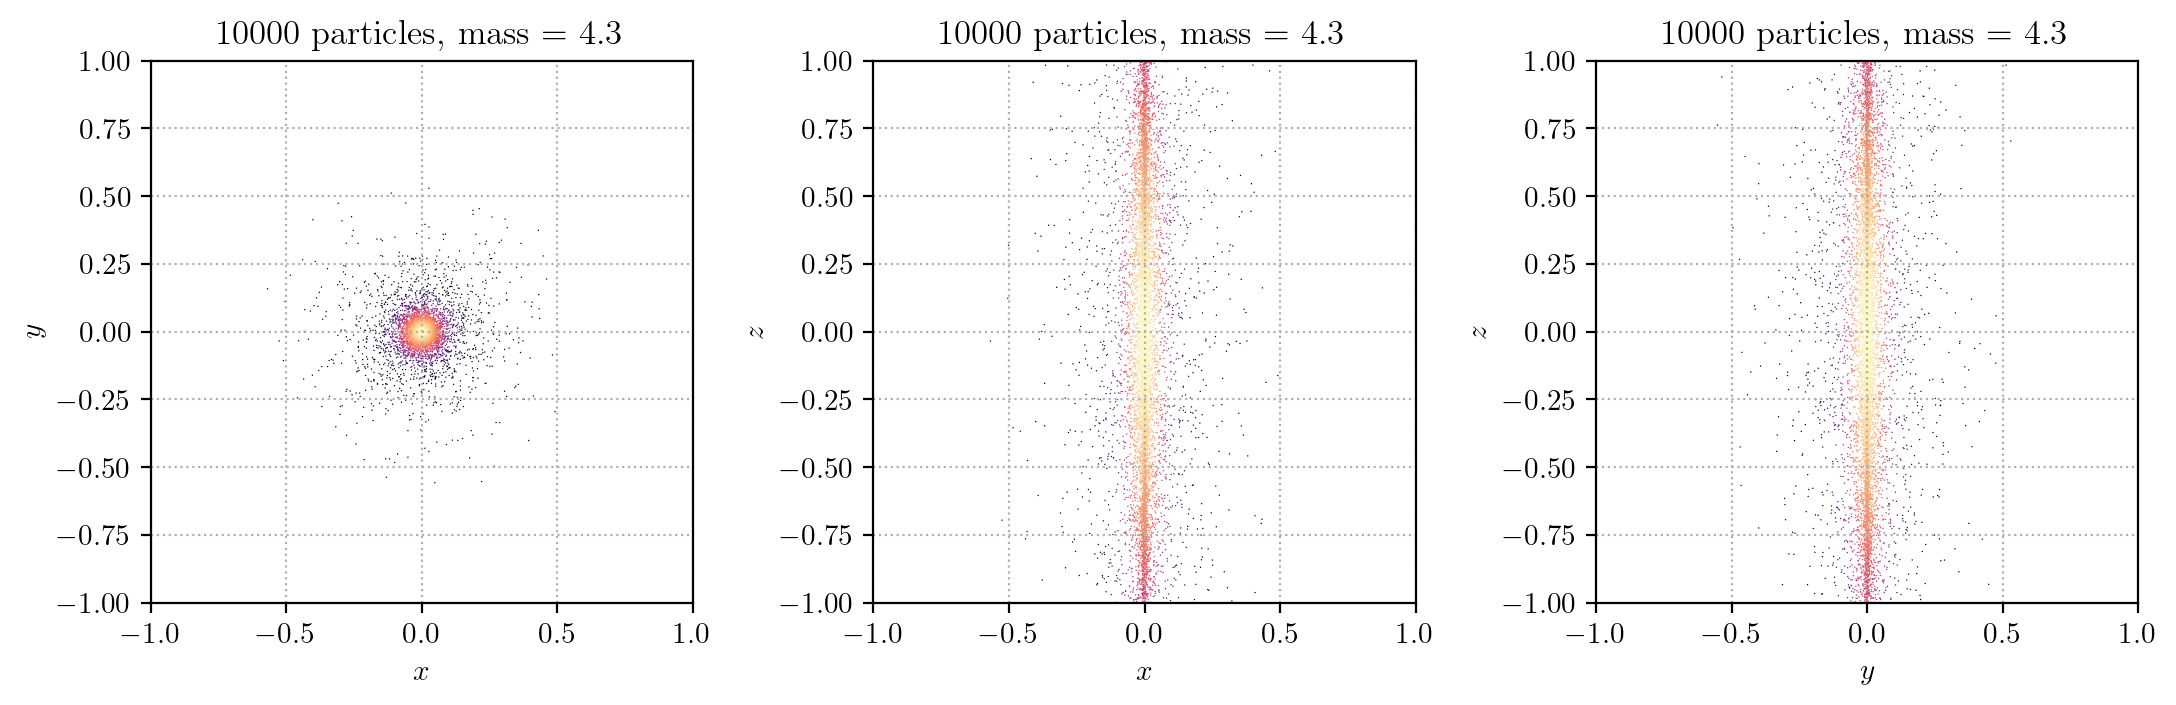

In [22]:
from gdsam import initial_data

disk = initial_data()
disk.set_positions(N, M_d, x,y,z)

disk.projections(l=1, s=.25, a=1)

plt.show()

## Altogether

In [23]:
total = initial_data()

total.N = 3*N
total.m = np.concatenate((bulge.m,disk.m,halo.m))
total.x = np.concatenate((bulge.x,disk.x,halo.x))
total.y = np.concatenate((bulge.y,disk.y,halo.y))
total.z = np.concatenate((bulge.z,disk.z,halo.z))

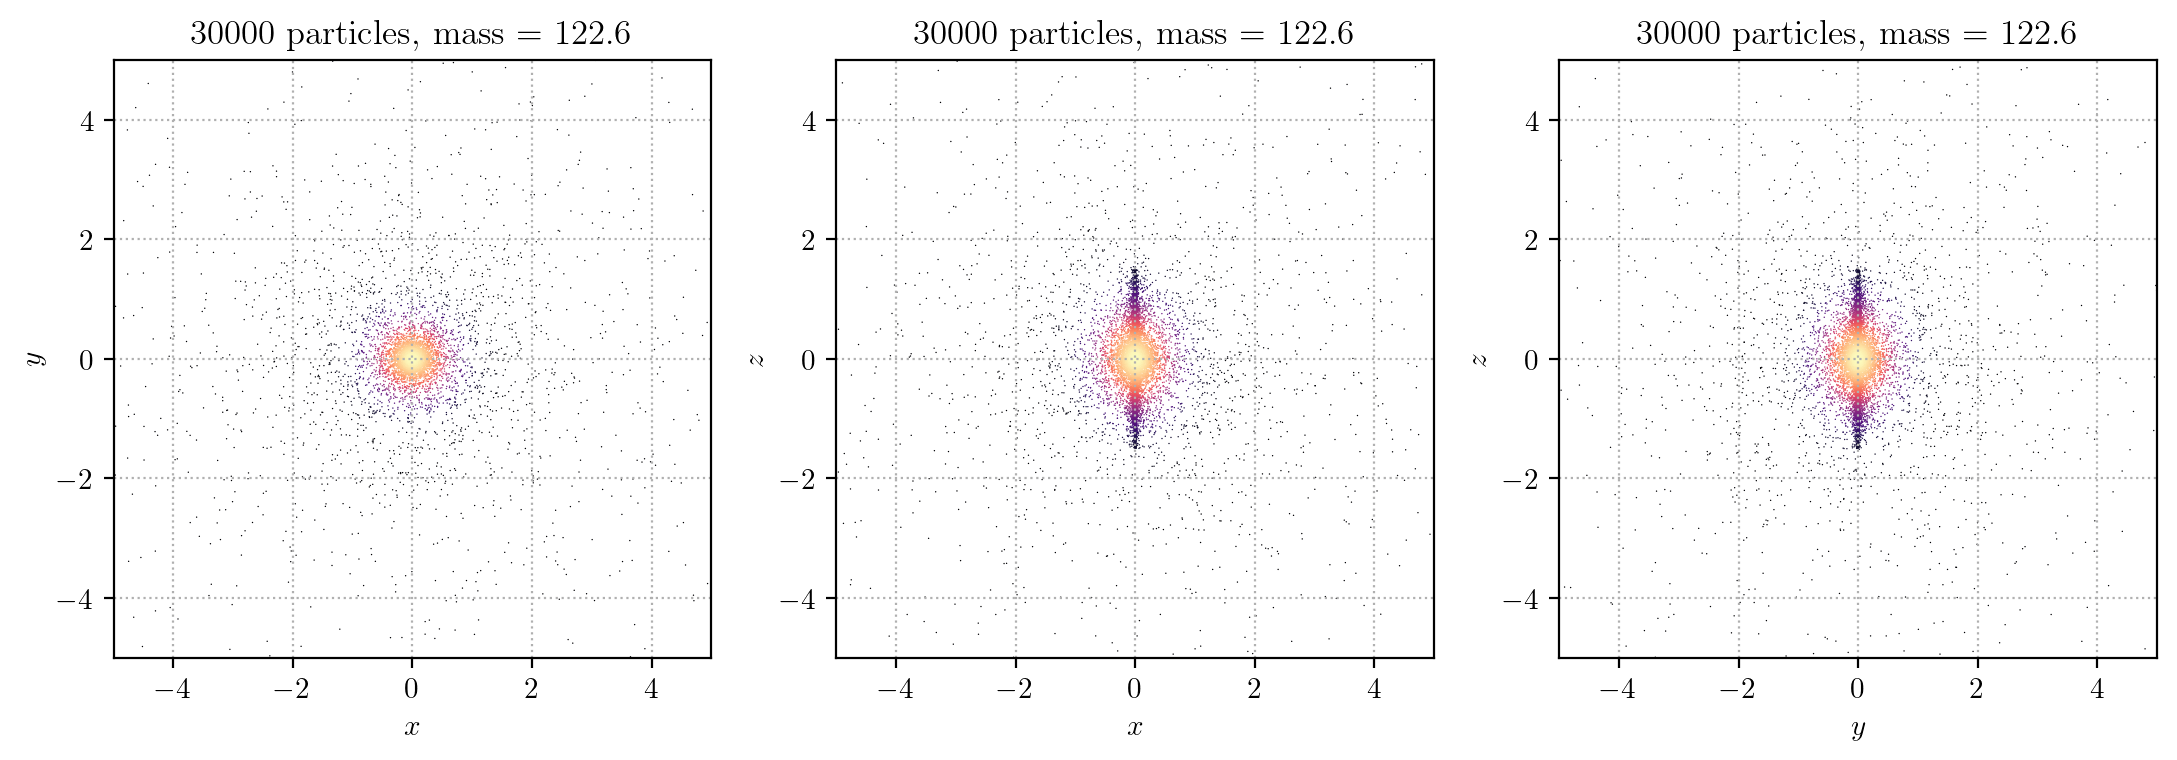

In [24]:
total.projections(l=5, s=.25, a=1, bw=.5)

plt.show()